<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_modelo_futuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Modelo futuro

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os, random

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from absl import logging as absl_logging

# Configurações

In [13]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-v0_8-darkgrid')

SEMENTE = 2001088 + 2001247 + 2003061 + 2005493 + 2008193 + 2008620 + 2008880

JANELA_TAMANHO        = 6
HORIZONTE_TAMANHO     = 1
QUANTIDADE_INTERVALOS = 8

LOTE_TAMANHO = 32

# CAMADAS = 4

# CAMADA_UNIDADES      = 64
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

PROFUNDO_POTENCIA_INICIAL = 5
PROFUNDO_POTENCIA_FINAL   = 13  # Não incluída
PROFUNDO_REPETICAO        = 2
PROFUNDO_CONSOLIDACAO     = 32

SAIDA_ATIVACAO = 'linear'

PERDA       = 'mae'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['mae', 'mse']

ITERACOES = 1000

CAMINHO_MARCOS = 'marcos'

# Define o nível de log Abseil para 'ERROR'.
# https://abseil.io/docs/python/guides/logging
absl_logging.set_verbosity(absl_logging.ERROR)

## Funções

In [14]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

--2023-03-20 00:15:00--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7246 (7.1K) [text/plain]
Saving to: ‘PJI410_funcoes_auxiliares.py.2’

PJI410_funcoes_auxi 100%[===================>]   7.08K  --.-KB/s    in 0s      

2023-03-20 00:15:00 (87.2 MB/s) - ‘PJI410_funcoes_auxiliares.py.2’ saved [7246/7246]



In [15]:
from PJI410_funcoes_auxiliares import criar_janelas, criar_marco_modelo, gerar_previsoes_futuro, grafico_series, metricas_modelo, separar_janelas_treino_teste, set_global_determinism

# Dados

In [16]:
df_populacao  = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_populacao.csv')
df_municipios = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_municipios.csv')
df_unidades   = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_unidades.csv')

df_notificacoes_por_unidade = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_notificacoes_por_unidade.zip', parse_dates=['Segunda-feira'])
df_notificacoes_por_unidade = df_notificacoes_por_unidade[['UF', 'Municipio', 'Unidade', 'Segunda-feira', 'Quantidade']]
df_notificacoes_por_unidade = df_notificacoes_por_unidade.sort_values(by=['UF', 'Municipio', 'Unidade', 'Segunda-feira']).reset_index(drop=True)

df_notificacoes_por_municipio = df_notificacoes_por_unidade[['UF', 'Municipio', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Municipio', 'Segunda-feira']).sum()
df_notificacoes_por_municipio = df_notificacoes_por_municipio.sort_index().reset_index()

df_notificacoes_por_uf = df_notificacoes_por_unidade[['UF', 'Segunda-feira', 'Quantidade']].groupby(by=['UF', 'Segunda-feira']).sum()
df_notificacoes_por_uf = df_notificacoes_por_uf.sort_index().reset_index()

df_notificacoes_por_semana = df_notificacoes_por_unidade[['Segunda-feira', 'Quantidade']].groupby(by=['Segunda-feira']).sum()
df_notificacoes_por_semana = df_notificacoes_por_semana.sort_index().reset_index()

quantidades = df_notificacoes_por_semana['Quantidade'].to_numpy().astype('float32')

In [17]:
# q_treino = int(len(dados) * 0.8)

# X_train = dados[:q_treino]['Segunda-feira'].to_numpy()
# y_train = dados[:q_treino]['Quantidade'].to_numpy()

# X_test = dados[q_treino:]['Segunda-feira'].to_numpy()
# y_test = dados[q_treino:]['Quantidade'].to_numpy()

# Modelo

In [18]:
%%time

set_global_determinism(seed=SEMENTE)

janelas, horizontes = criar_janelas(quantidades, JANELA_TAMANHO, HORIZONTE_TAMANHO)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

modelo_nome = 'modelo_futuro'

modelo_futuro = Sequential(name=modelo_nome)

for potencia in range(PROFUNDO_POTENCIA_INICIAL, PROFUNDO_POTENCIA_FINAL):
    unidades = 2 ** potencia
    [modelo_futuro.add(Dense(units=unidades, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO, name=f'camada_oculta_{unidades}_{r}')) for r in range(PROFUNDO_REPETICAO)]

modelo_futuro.add(Dense(units=PROFUNDO_CONSOLIDACAO, activation=CAMADA_ATIVACAO, name='camada_consolidacao'))
modelo_futuro.add(Dense(units=HORIZONTE_TAMANHO, activation=SAIDA_ATIVACAO, name='camada_saida'))

modelo_futuro.compile(loss=PERDA, optimizer=OTIMIZADOR(learning_rate=APRENDIZADO), metrics=METRICAS)

modelo_futuro.fit(x=janelas_treino,
                  y=horizontes_treino,
                  epochs=ITERACOES,
                  batch_size=LOTE_TAMANHO,
                  validation_data=(janelas_teste, horizontes_teste),
                  callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=0),
                             criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
                  verbose=0)

modelo_futuro = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))

previsoes = modelo_futuro.predict(janelas_teste, verbose=0)
metricas  = metricas_modelo(horizontes_teste[:, -1], y_previsao=previsoes[:, -1])

print(metricas)

{'Mean Absolute Error': 516.5684, 'Root Mean Squared Error': 757.40094, 'Mean Absolute Percentage Error': 0.1261943}
CPU times: user 1min 29s, sys: 6.53 s, total: 1min 35s
Wall time: 2min 25s


In [19]:
modelo_futuro.summary()

Model: "modelo_futuro"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_oculta_32_0 (Dense)  (None, 32)                224       
                                                                 
 camada_oculta_32_1 (Dense)  (None, 32)                1056      
                                                                 
 camada_oculta_64_0 (Dense)  (None, 64)                2112      
                                                                 
 camada_oculta_64_1 (Dense)  (None, 64)                4160      
                                                                 
 camada_oculta_128_0 (Dense)  (None, 128)              8320      
                                                                 
 camada_oculta_128_1 (Dense)  (None, 128)              16512     
                                                                 
 camada_oculta_256_0 (Dense)  (None, 256)            

## Testes

In [20]:
# uf_cod  = 'MG'
# uf_desc = df_populacao['Nome'][df_populacao['UF'] == uf_cod].values[0]

# dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
# local = f" {uf_cod} - {uf_desc}"

In [36]:
lo = random.randint(0, 2)
dados = []
local = ''

while(len(dados) <= 16):
    if(lo == 0):
        uf_cod, uf_desc = df_populacao[['UF', 'Nome']].sample().values[0]
        dados = df_notificacoes_por_uf[df_notificacoes_por_uf['UF'] == uf_cod]
        local = f" {uf_cod} - {uf_desc}"
    elif(lo == 1):
        mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']].sample().values[0]
        dados = df_notificacoes_por_municipio[df_notificacoes_por_municipio['Municipio'] == mu_cod]

        if len(dados) > 0:
            local = f"\n{mu_cod} - {mu_desc} ({dados['UF'].values[0]})"
    else:
        un_cod, un_desc = df_unidades[['Codigo', 'Unidade']].sample().values[0]
        dados = df_notificacoes_por_unidade[df_notificacoes_por_unidade['Unidade'] == un_cod]

        if len(dados) > 0:
            mu_cod, mu_desc = df_municipios[['Codigo', 'Municipio']][df_municipios['Codigo'] == dados['Municipio'].values[0]].values[0]
            local = f"\n{mu_cod} - {mu_desc} ({dados['UF'].values[0]})\nUnidade {un_cod} - {un_desc}"

In [37]:
X_train = dados[:-QUANTIDADE_INTERVALOS]['Segunda-feira'].to_numpy()
y_train = dados[:-QUANTIDADE_INTERVALOS]['Quantidade'].to_numpy()

X_test = dados[-QUANTIDADE_INTERVALOS:]['Segunda-feira'].to_numpy()
y_test = dados[-QUANTIDADE_INTERVALOS:]['Quantidade'].to_numpy()

y_pred = gerar_previsoes_futuro(modelo_futuro, y_train, QUANTIDADE_INTERVALOS, JANELA_TAMANHO)

# Inclui o último valor de treino no teste e na previsão, para o gráfico não parecer quebrado.
X_test = np.insert(X_test, 0, X_train[-1])
y_test = np.insert(y_test, 0, y_train[-1])
y_pred = np.insert(y_pred, 0, y_train[-1])

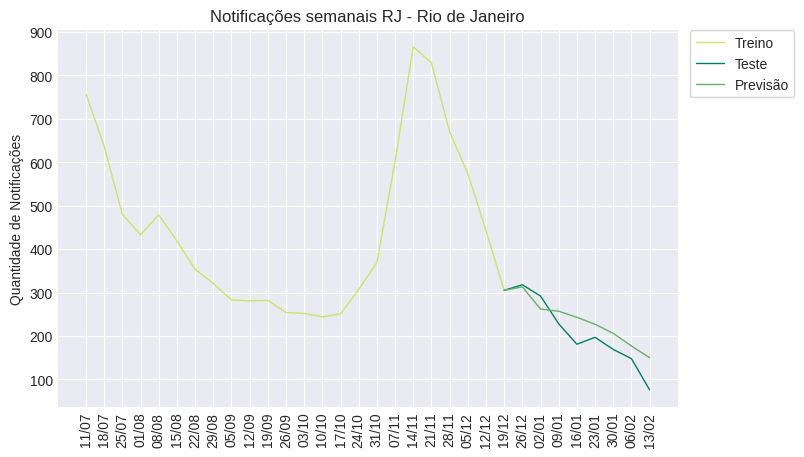

In [38]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test,
               X_previsao=X_test, y_previsao=y_pred,
               inicio=-24, local=local)